 # Distributed Deep Reinforcement Learning for Multiple Stock Trading

 <a id='0'></a>
 # Part 1. Problem Definition

 This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

 The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


 * Action: The action space describes the allowed actions that the agent interacts with the
 environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
 selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
 an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

 * Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
 values at state s′ and s, respectively

 * State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
 our trading agent observes many different features to better learn in an interactive environment.

 * Environment: Dow 30 consituents


 The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


 <a id='1'></a>
 # Part 2. Getting Started- Load Python Packages

 <a id='1.1'></a>
 ## 2.1. Install all required packages


In [1]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
!git clone https://github.com/facebookresearch/torchbeast.git
!pip install -r torchbeast/requirements.txt

Cloning into 'torchbeast'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 300 (delta 71), reused 59 (delta 59), pack-reused 202
Receiving objects: 100% (300/300), 5.69 MiB | 344.00 KiB/s, done.
Resolving deltas: 100% (152/152), done.
  Using cached atari-py-0.2.5.tar.gz (790 kB)
  Using cached black-21.12b0-py3-none-any.whl (156 kB)
  Using cached ale_py-0.7.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached mypy_extensions-0.4.3-py2.py3-none-any.whl (4.5 kB)
  Using cached pathspec-0.9.0-py2.py3-none-any.whl (31 kB)
  Using cached filelock-3.4.2-py3-none-any.whl (9.9 kB)
  ERROR: Command errored out with exit status 1:
   command: /home/tcai/miniconda3/envs/dwai/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-wuwnvrom/atari-py/setup.py'"'"'; __file__='"'"'/tmp/pip-install-wuwnvrom/atari-py/setup.py'"'"';f=getatt


 <a id='1.2'></a>
 ## 2.2. Check if the additional packages needed are present, if not install them.
 * Yahoo Finance API
 * pandas
 * numpy
 * matplotlib
 * stockstats
 * OpenAI gym
 * stable-baselines
 * tensorflow
 * pyfolio

 <a id='1.3'></a>
 ## 2.3. Import Packages

In [2]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from drl_agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_baseline

import impala

from pprint import pprint
from absl import flags

FLAGS = flags.FLAGS
FLAGS(sys.argv, known_only=True)

import sys
sys.path.append("../FinRL-Library")

import itertools
import logging

logging.basicConfig(level=logging.INFO)


/home/tcai/miniconda3/envs/dwai/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
/home/tcai/miniconda3/envs/dwai/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


 <a id='1.4'></a>
 ## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

 <a id='2'></a>
 # Part 3. Download Data
 Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
 * FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
 * Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




 -----
 class YahooDownloader:
     Provides methods for retrieving daily stock data from
     Yahoo Finance API

     Attributes
     ----------
         start_date : str
             start date of the data (modified from config.py)
         end_date : str
             end date of the data (modified from config.py)
         ticker_list : list
             a list of stock tickers (modified from config.py)

     Methods
     -------
     fetch_data()
         Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE


'2009-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE


'2021-10-31'

In [6]:
print(config.DOW_30_TICKER)


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [11]:
data_filename = 'processed_data.csv'
data_path = os.path.join(config.DATA_SAVE_DIR, data_filename)

if os.path.exists(data_path):
    data = pd.read_csv(data_path)
else:
    data = None


In [12]:
if data is None:
    df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config.DOW_30_TICKER).fetch_data()


In [13]:
if data is None:
  df.shape


In [14]:
if data is None:
  df.sort_values(['date','tic'],ignore_index=True).head()


 # Part 4: Preprocess Data
 Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
 * Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
 * Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [15]:
if data is None:
    fe = FeatureEngineer(
                        use_technical_indicator=True,
                        tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                        use_vix=True,
                        use_turbulence=True,
                        user_defined_feature = False)

    processed = fe.preprocess_data(df)


In [16]:
if data is None:
    list_ticker = processed["tic"].unique().tolist()
    list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
    combination = list(itertools.product(list_date,list_ticker))

    processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
    processed_full = processed_full[processed_full['date'].isin(processed['date'])]
    processed_full = processed_full.sort_values(['date','tic'])

    processed_full = processed_full.fillna(0)
    processed_full.to_csv(data_path, index=False)
    
else:
    processed_full = data


In [17]:
processed_full['date'] = pd.to_datetime(processed_full['date'])
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.613433,607541200.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,2.613433,2.613433,40.0,0.0
1,2008-12-31,AMGN,57.110001,58.220001,57.060001,44.657005,6287200.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,44.657005,44.657005,40.0,0.0
2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.950778,9625600.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,14.950778,14.950778,40.0,0.0
3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005886,5443100.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,32.005886,32.005886,40.0,0.0
4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.925043,6277400.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,30.925043,30.925043,40.0,0.0
5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.868505,37513700.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,11.868505,11.868505,40.0,0.0
7,2008-12-31,CVX,72.900002,74.629997,72.900002,44.129253,9964300.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,44.129253,44.129253,40.0,0.0
8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538343,9012100.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,19.538343,19.538343,40.0,0.0
9,2008-12-31,GS,82.239998,86.150002,81.120003,69.632233,14894100.0,2.0,0.0,2.929945,2.462269,100.0,66.666667,100.0,69.632233,69.632233,40.0,0.0


 <a id='4'></a>
 # Part 5. Design Environment
 Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

 Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

 The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

 ## Training data split: 2009-01-01 to 2020-07-01
 ## Trade data split: 2020-07-01 to 2021-10-31

In [18]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))


83897
9744


In [19]:
train.tail()


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,288.628387,2932900.0,1.0,-0.019538,304.825269,272.053921,52.413047,-25.815270,1.846804,288.873005,281.832984,30.43,12.918808
2892,2020-06-30,V,191.490005,193.750000,190.160004,191.412445,9040100.0,1.0,1.052501,199.454085,185.696446,53.021038,-51.516695,2.013358,192.162886,182.320814,30.43,12.918808
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,50.990158,17414800.0,1.0,-0.442433,54.574965,49.322678,48.097046,-50.972323,8.508886,51.633274,52.091341,30.43,12.918808
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,39.892540,4782100.0,1.0,-0.085829,43.544545,37.287958,48.830190,-14.445134,1.500723,39.994175,39.789724,30.43,12.918808
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,116.994621,6836400.0,1.0,-0.893233,120.371803,114.363676,48.159675,-69.914656,3.847271,118.672997,120.623193,30.43,12.918808


In [20]:
trade.head()


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.151405,110737200.0,2.0,3.022879,92.953798,80.400063,62.807135,107.487530,29.730532,84.164183,77.930893,28.620001,53.06823
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,244.159119,6575800.0,2.0,3.697037,236.273225,203.552000,61.279633,271.769133,46.806139,218.441969,219.532869,28.620001,53.06823
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.347778,3301000.0,2.0,-0.390267,110.737387,88.008446,48.504819,-66.334508,3.142448,97.520673,90.952973,28.620001,53.06823
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.06823
0,2020-07-01,CAT,129.380005,129.399994,125.879997,121.818474,2807800.0,2.0,1.284937,131.887567,114.449388,52.865416,35.546899,14.457404,120.567699,114.745772,28.620001,53.06823


In [21]:
config.TECHNICAL_INDICATORS_LIST


['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [22]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")



Stock Dimension: 29, State Space: 291


 ## Environment for Training



In [23]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)


 ## Trading
 Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

 ### Set turbulence threshold
 Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [24]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])


In [25]:
insample_risk_indicator.vix.describe()


count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [26]:
insample_risk_indicator.vix.quantile(0.996)


57.40400183105453

In [27]:
insample_risk_indicator.turbulence.describe()


count    2893.000000
mean       34.574231
std        43.787144
min         0.000000
25%        14.965867
50%        24.123804
75%        39.162151
max       652.503472
Name: turbulence, dtype: float64

In [28]:
insample_risk_indicator.turbulence.quantile(0.996)


276.44987310008247

In [29]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

# Part 6: Implement DRL Algorithms

## Training

In [30]:
impala.config.env = e_train_gym
impala.train(FLAGS)

[DEBUG:11291 cmd:869 2022-01-09 12:04:13,382] Popen(['git', 'version'], cwd=/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project, universal_newlines=False, shell=None, istream=None)
[DEBUG:11291 cmd:869 2022-01-09 12:04:13,428] Popen(['git', 'version'], cwd=/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project, universal_newlines=False, shell=None, istream=None)
[DEBUG:11291 cmd:869 2022-01-09 12:04:13,515] Popen(['git', 'cat-file', '--batch-check'], cwd=/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs, universal_newlines=False, shell=None, istream=<valid stream>)
[DEBUG:11291 cmd:869 2022-01-09 12:04:13,611] Popen(['git', 'diff', '--cached', '--abbrev=40', '--full-index', '--raw'], cwd=/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs, universal_newlines=False, shell=None, istream=None)
[DEBUG:11291 cmd:869 2022-01-09 12:04:13,698] Popen(['git', 'diff', '--abbrev=40', '--full-index', '--raw'], cwd=/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs, universal_newlines=False, shell=None, istr

ActorNet(
  (net_state): Sequential(
    (0): Linear(in_features=291, out_features=512, bias=True)
    (1): ReLU()
  )
  (core): LSTM(542, 542, num_layers=2)
  (net_policy): Sequential(
    (0): ReLU()
    (1): Linear(in_features=542, out_features=512, bias=True)
    (2): Hardswish()
    (3): Linear(in_features=512, out_features=29, bias=True)
  )
  (net_action_std): Sequential(
    (0): Hardswish()
    (1): Linear(in_features=542, out_features=29, bias=True)
  )
  (baseline): Sequential(
    (0): ReLU()
    (1): Linear(in_features=542, out_features=1, bias=True)
  )
)


[INFO:11598 impala:146 2022-01-09 12:04:14,647] Actor 0 started.
[INFO:11599 impala:146 2022-01-09 12:04:14,657] Actor 1 started.
[ERROR:11598 impala:196 2022-01-09 12:04:14,678] Exception in worker process 0
[ERROR:11599 impala:196 2022-01-09 12:04:14,685] Exception in worker process 1
Traceback (most recent call last):
[INFO:11605 impala:146 2022-01-09 12:04:14,703] Actor 3 started.
[INFO:11600 impala:146 2022-01-09 12:04:14,713] Actor 2 started.
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/impala.py", line 153, in act
    env_output = env.initial()
Traceback (most recent call last):
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/impala.py", line 153, in act
    env_output = env.initial()
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/torchbeast/torchbeast/core/environment.py", line 37, in initial
    initial_frame = _format_frame(self.gym_env.reset())
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/torchbeast/torchbeas

Process ForkProcess-2:
[ERROR:11605 impala:196 2022-01-09 12:04:14,755] Exception in worker process 3
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/torchbeast/torchbeast/core/environment.py", line 20, in _format_frame
    frame = torch.from_numpy(frame)
[ERROR:11600 impala:196 2022-01-09 12:04:14,777] Exception in worker process 2
TypeError: expected np.ndarray (got list)
[INFO:11291 impala:422 2022-01-09 12:04:14,780] # Step	total_loss	mean_episode_return	pg_loss	baseline_loss	entropy_loss


Process ForkProcess-1:
Traceback (most recent call last):
  File "/home/tcai/miniconda3/envs/dwai/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/tcai/miniconda3/envs/dwai/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/impala.py", line 199, in act
    raise e
Traceback (most recent call last):
Traceback (most recent call last):


ActorNet(
  (net_state): Sequential(
    (0): Linear(in_features=291, out_features=512, bias=True)
    (1): ReLU()
  )
  (core): LSTM(542, 542, num_layers=2)
  (net_policy): Sequential(
    (0): ReLU()
    (1): Linear(in_features=542, out_features=512, bias=True)
    (2): Hardswish()
    (3): Linear(in_features=512, out_features=29, bias=True)
  )
  (net_action_std): Sequential(
    (0): Hardswish()
    (1): Linear(in_features=542, out_features=29, bias=True)
  )
  (baseline): Sequential(
    (0): ReLU()
    (1): Linear(in_features=542, out_features=1, bias=True)
  )
)


  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/impala.py", line 153, in act
    env_output = env.initial()
Traceback (most recent call last):
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/impala.py", line 153, in act
    env_output = env.initial()
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/impala.py", line 153, in act
    env_output = env.initial()
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/torchbeast/torchbeast/core/environment.py", line 37, in initial
    initial_frame = _format_frame(self.gym_env.reset())
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/torchbeast/torchbeast/core/environment.py", line 37, in initial
    initial_frame = _format_frame(self.gym_env.reset())
  File "/home/tcai/miniconda3/envs/dwai/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/torchbeast/torchbeast/core/environment.py", l

Process ForkProcess-3:
TypeError: expected np.ndarray (got list)


  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/torchbeast/torchbeast/core/environment.py", line 20, in _format_frame
    frame = torch.from_numpy(frame)
Process ForkProcess-4:
TypeError: expected np.ndarray (got list)
Traceback (most recent call last):
  File "/home/tcai/miniconda3/envs/dwai/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/tcai/miniconda3/envs/dwai/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/tcai/miniconda3/envs/dwai/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/project/impala.py", line 199, in act
    raise e
  File "/home/tcai/miniconda3/envs/dwai/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/e/School/KTH/Y2P2/ID2223-Scalable-ML/labs/p

 ### Trade

 DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

 Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
impala.config.env = e_trade_gym
df_account_value, df_actions = impala.test(FLAGS)

hit end!


In [ ]:
df_account_value.shape

(336, 2)

In [ ]:
df_account_value.tail()


,date,account_value
331,2021-10-22,1.417986e+06
332,2021-10-25,1.422822e+06
333,2021-10-26,1.424533e+06
334,2021-10-27,1.415778e+06
335,2021-10-28,1.423982e+06


 <a id='6'></a>
 # Part 7: Backtest Our Strategy
 Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

 <a id='6.1'></a>
 ## 7.1 BackTestStats
 pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')


==============Get Backtest Results===========
Annual return          0.303552
Cumulative returns     0.423982
Annual volatility      0.140498
Sharpe ratio           1.963504
Calmar ratio           3.575612
Stability              0.950191
Max drawdown          -0.084895
Omega ratio            1.394761
Sortino ratio          2.992078
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.023354
Daily value at risk   -0.016606
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')



[DEBUG:31296 connectionpool:937 2022-01-08 23:47:01,532] Starting new HTTPS connection (1): query2.finance.yahoo.com:443


==============Get Baseline Stats===========


[DEBUG:31296 connectionpool:433 2022-01-08 23:47:02,243] https://query2.finance.yahoo.com:443 "GET /v8/finance/chart/%5EDJI?period1=1593554400&period2=1635372000&interval=1d&includePrePost=False&events=div%2Csplits HTTP/1.1" 200 None


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (336, 8)
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64


In [ ]:
df_account_value.loc[0,'date']


'2020-07-01'

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']


'2021-10-28'

 <a id='6.2'></a>
 ## 7.2 BackTestPlot

In [ ]:
print("==============Compare to DJIA===========")

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])


[DEBUG:9476 pyplot:280 2022-01-09 10:42:42,890] Loaded backend module://matplotlib_inline.backend_inline version unknown.


==============Compare to DJIA===========


NameError: name 'df_account_value' is not defined

<a id='6.3'></a>
## 7.3 TransactionPlot

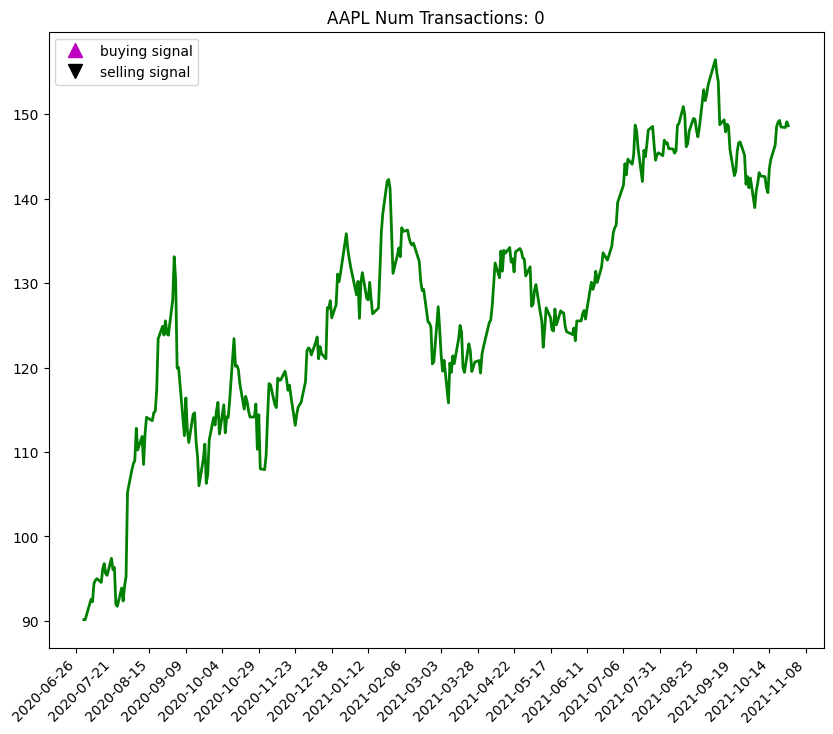

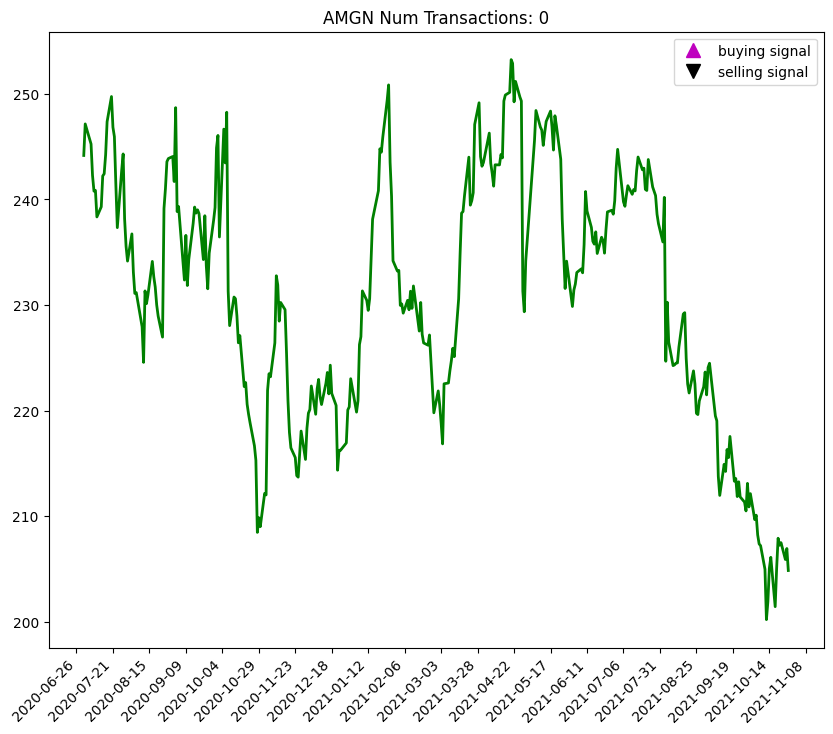

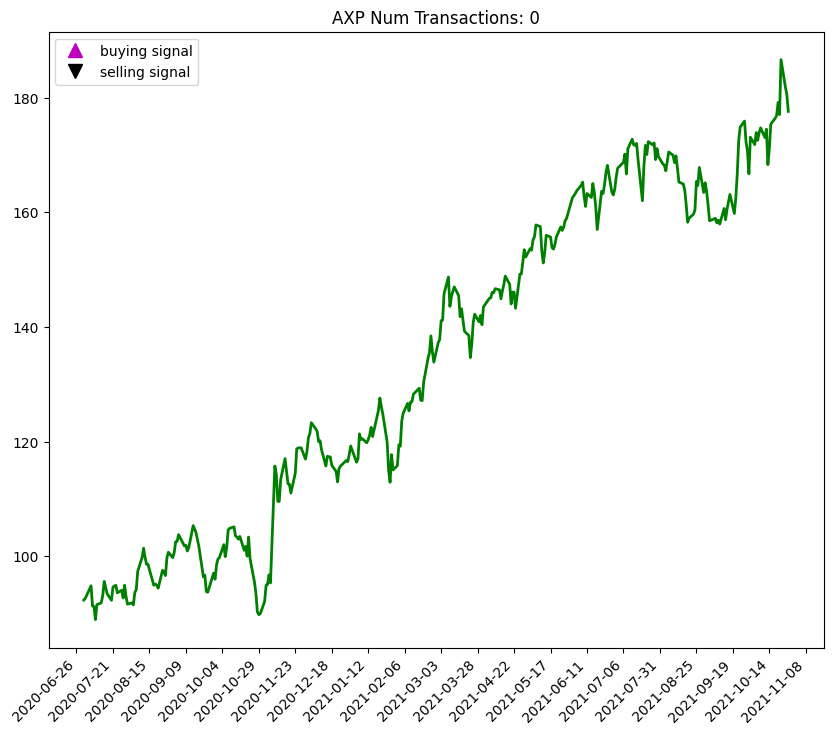

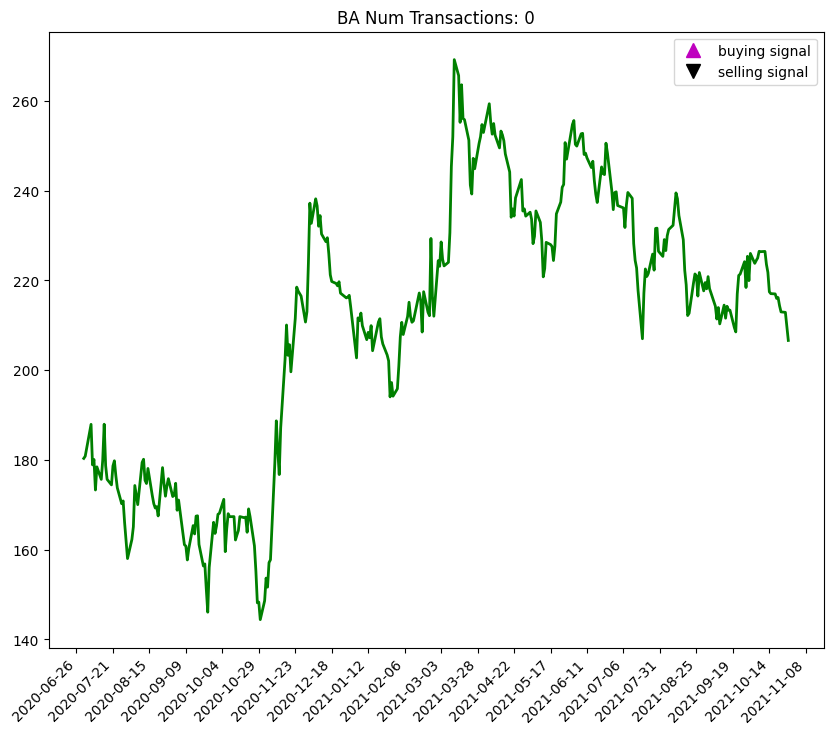

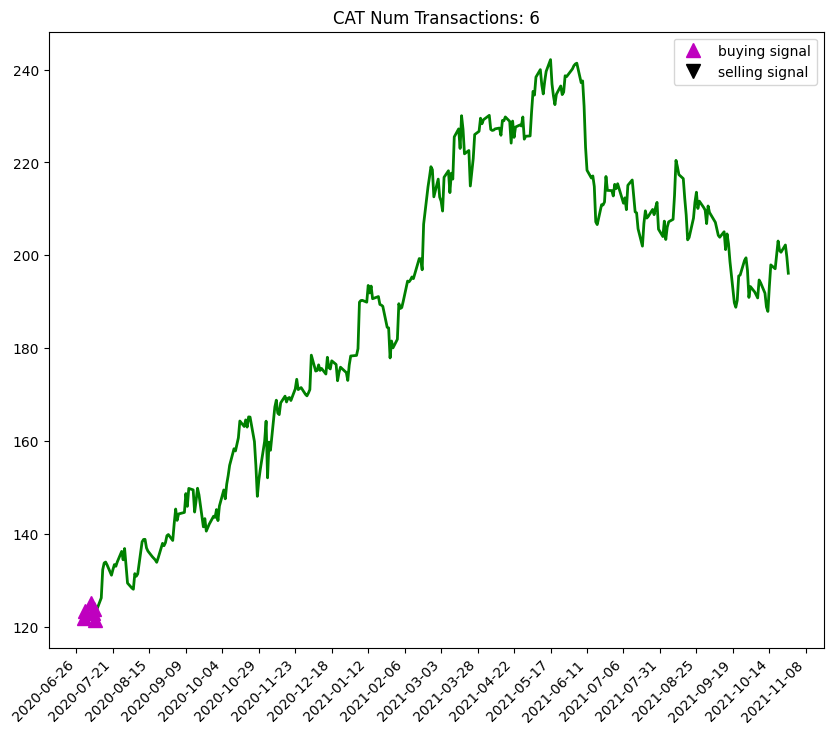

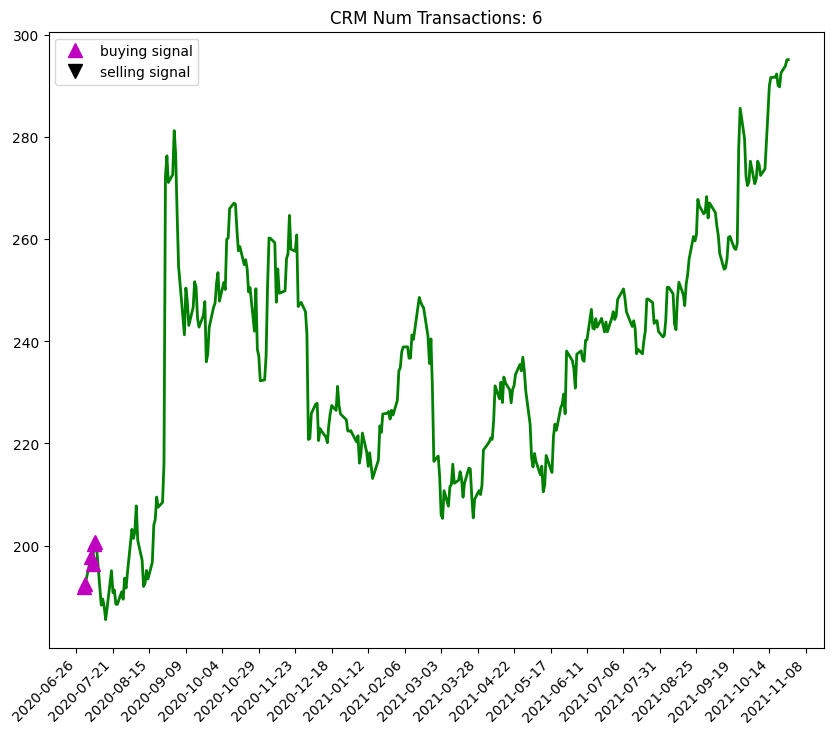

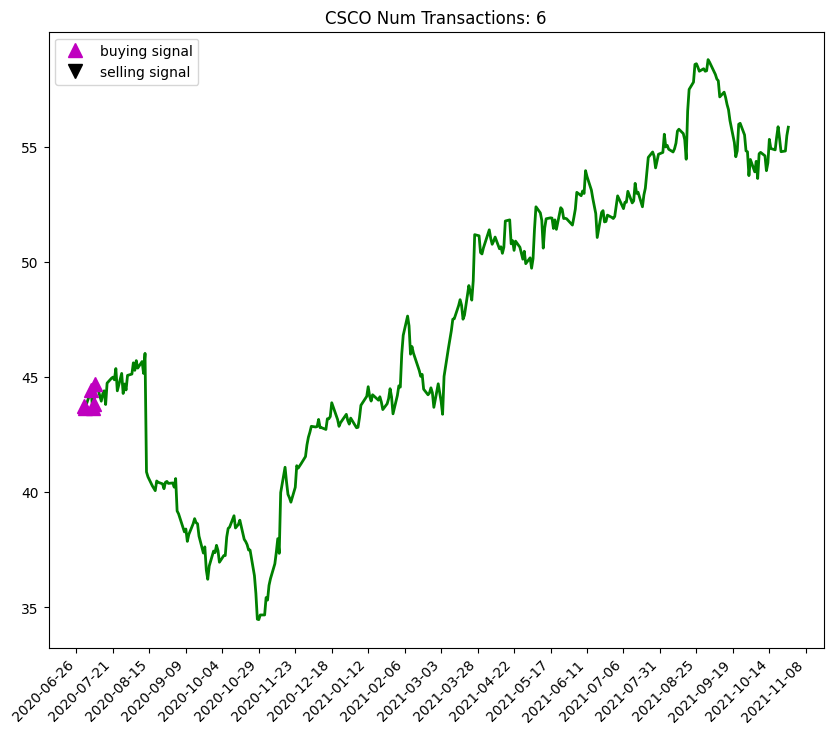

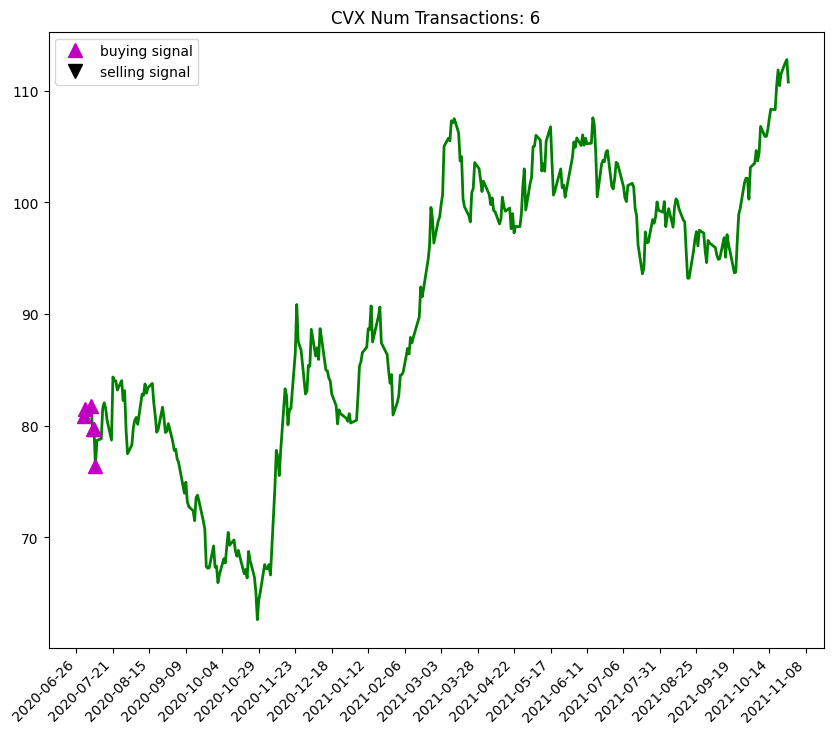

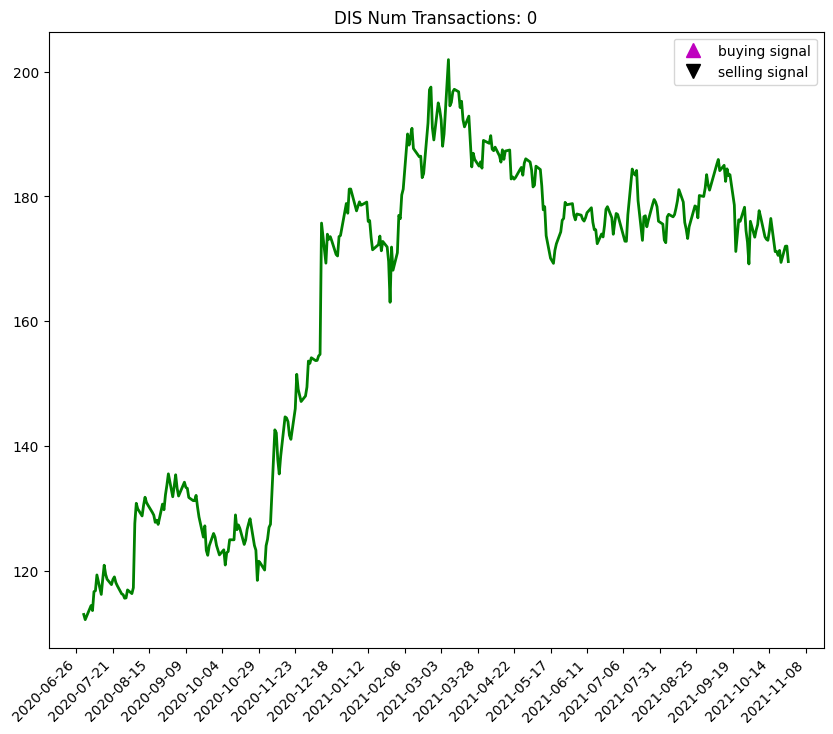

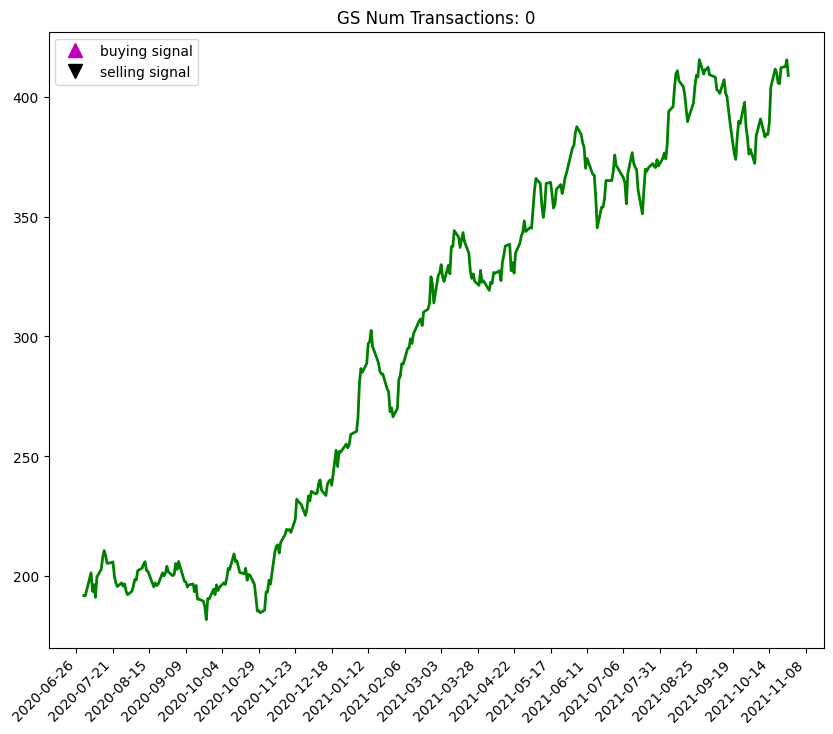

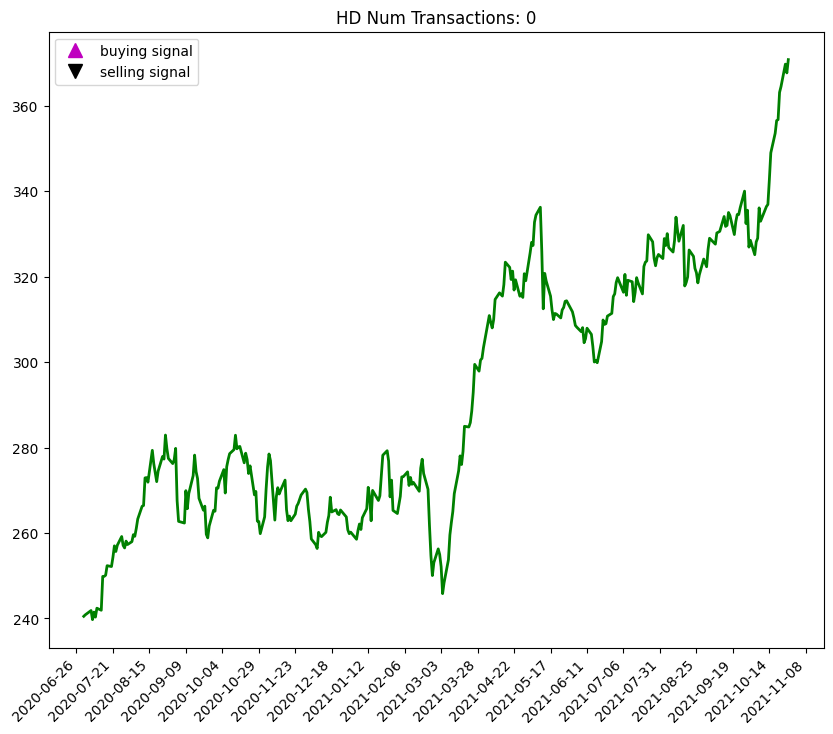

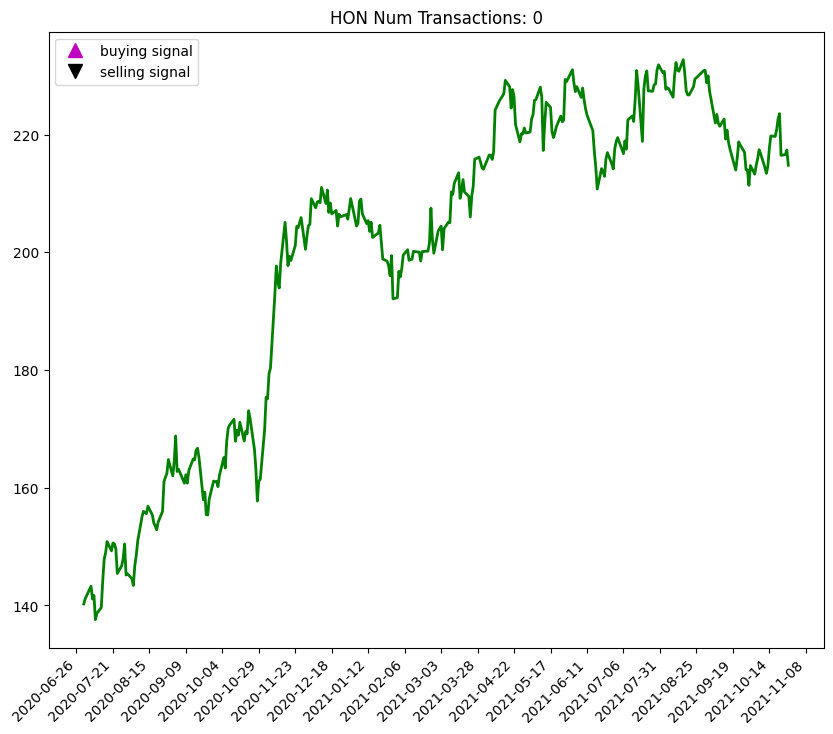

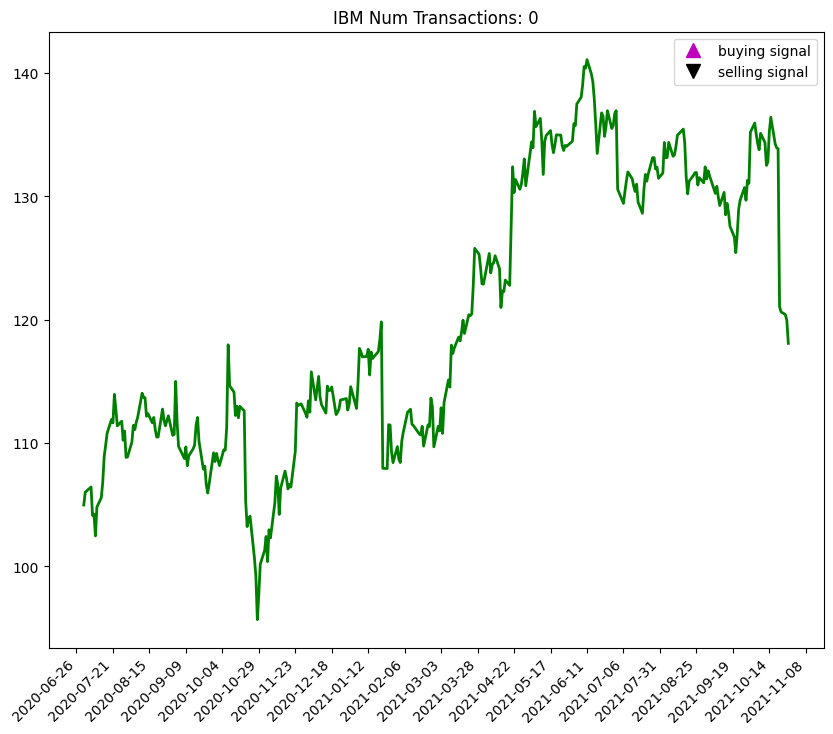

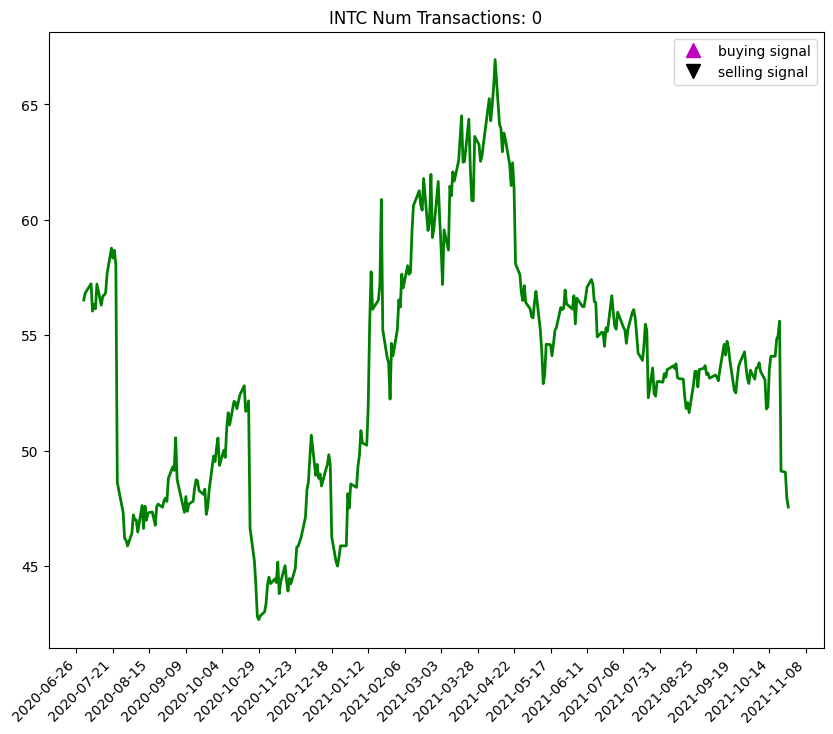

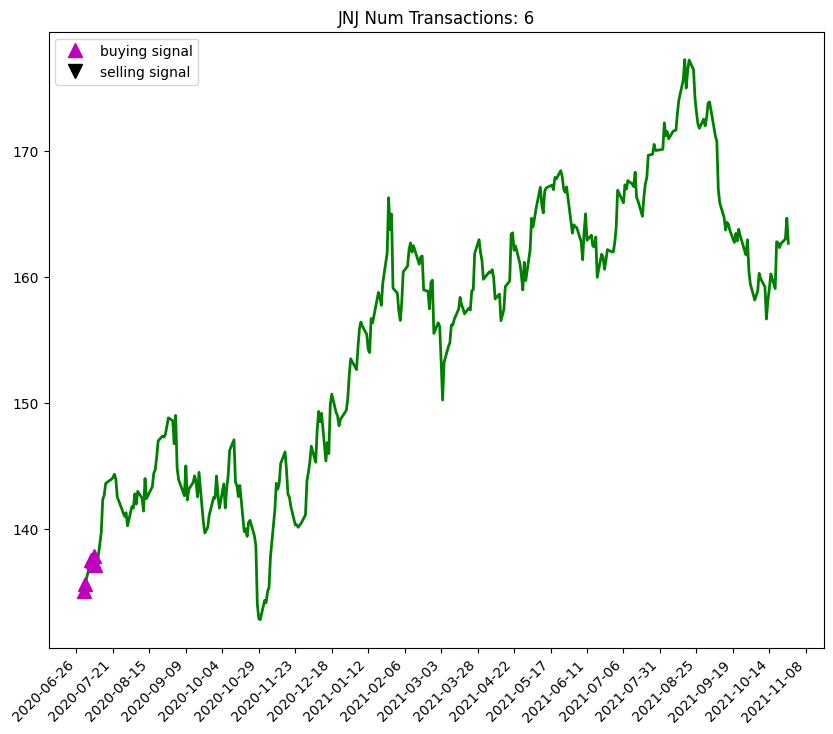

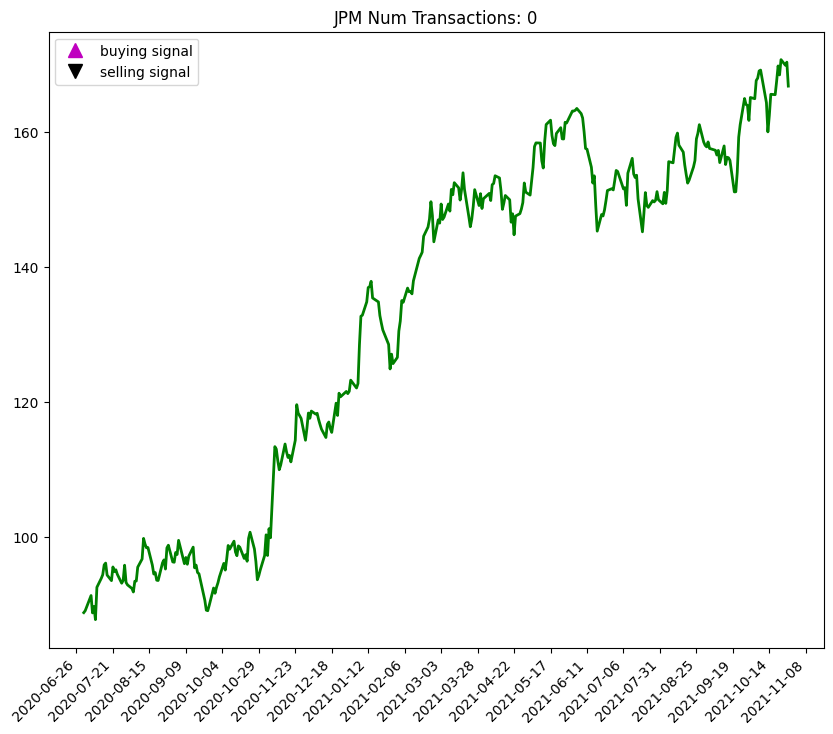

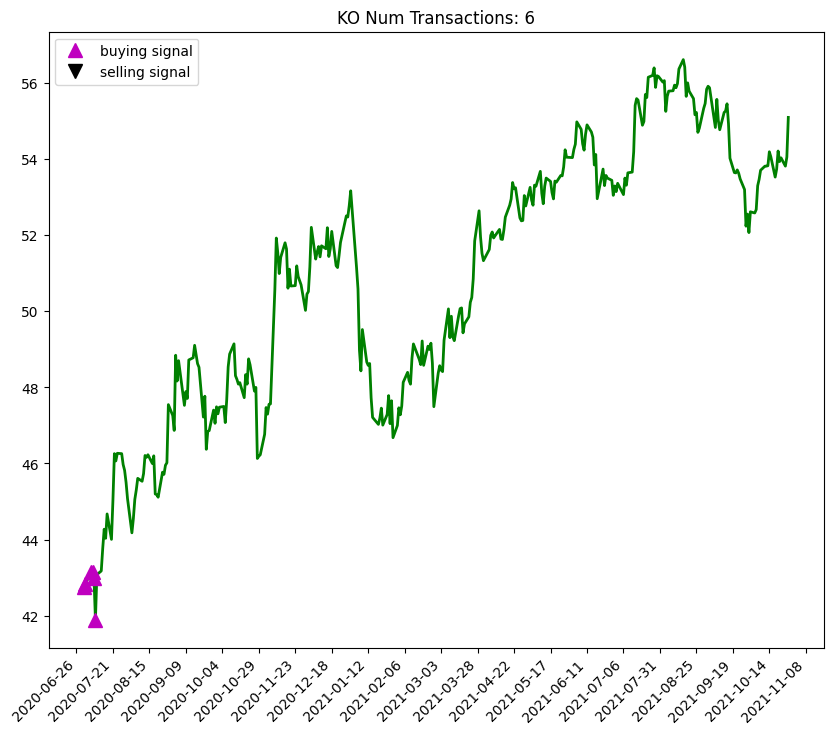

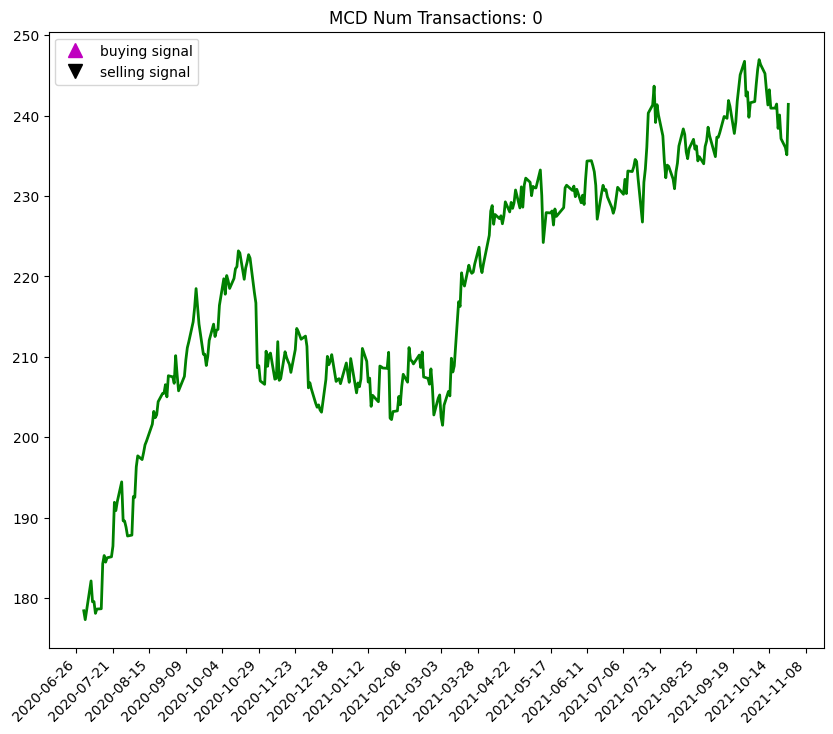

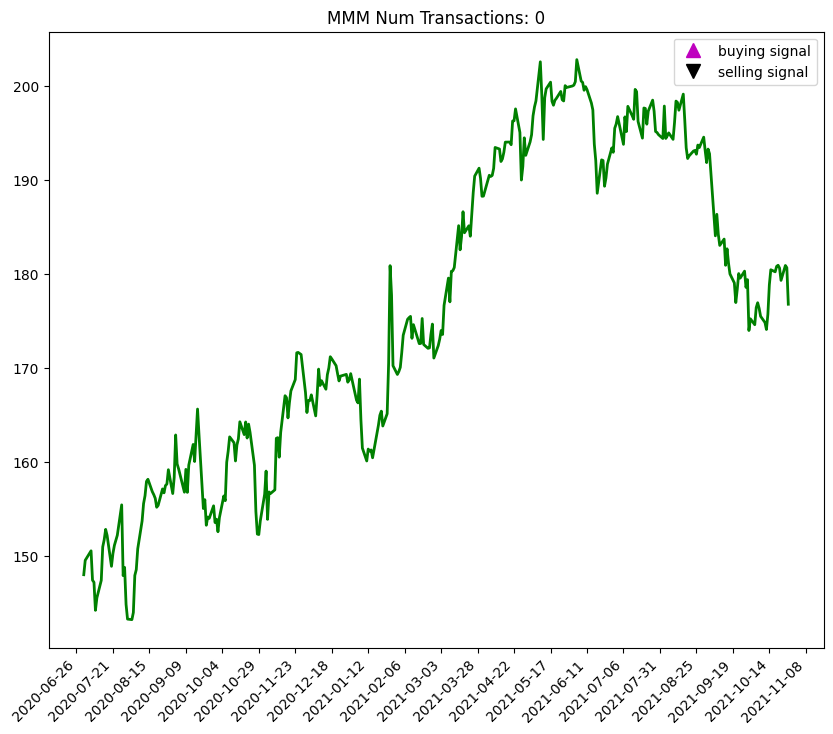

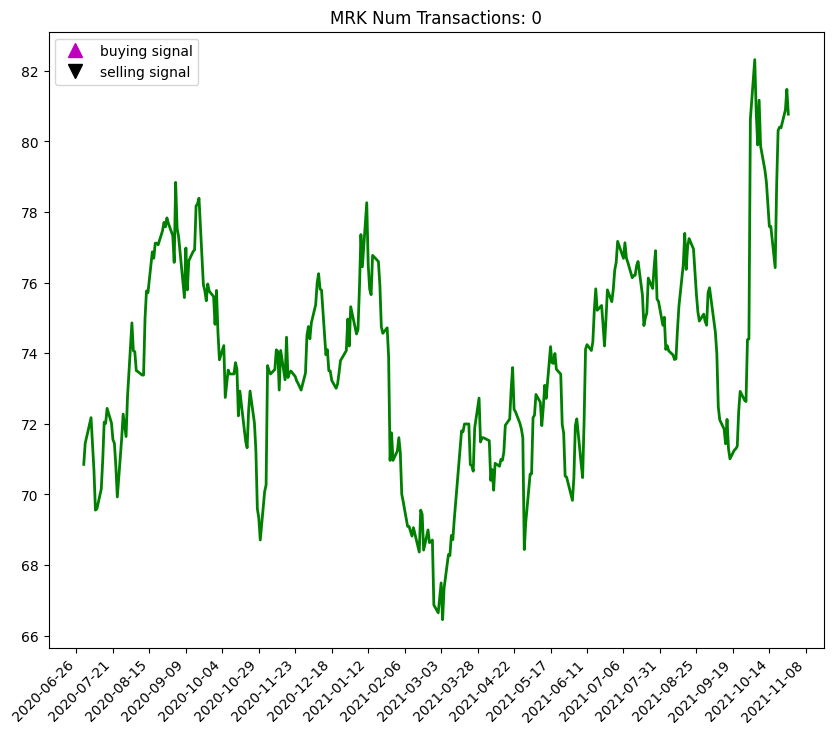

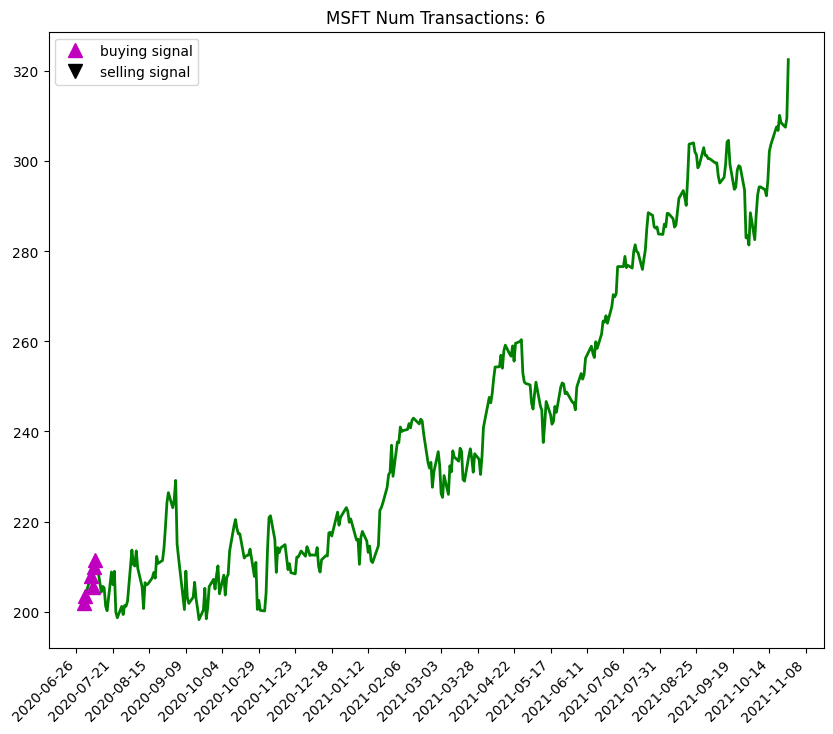

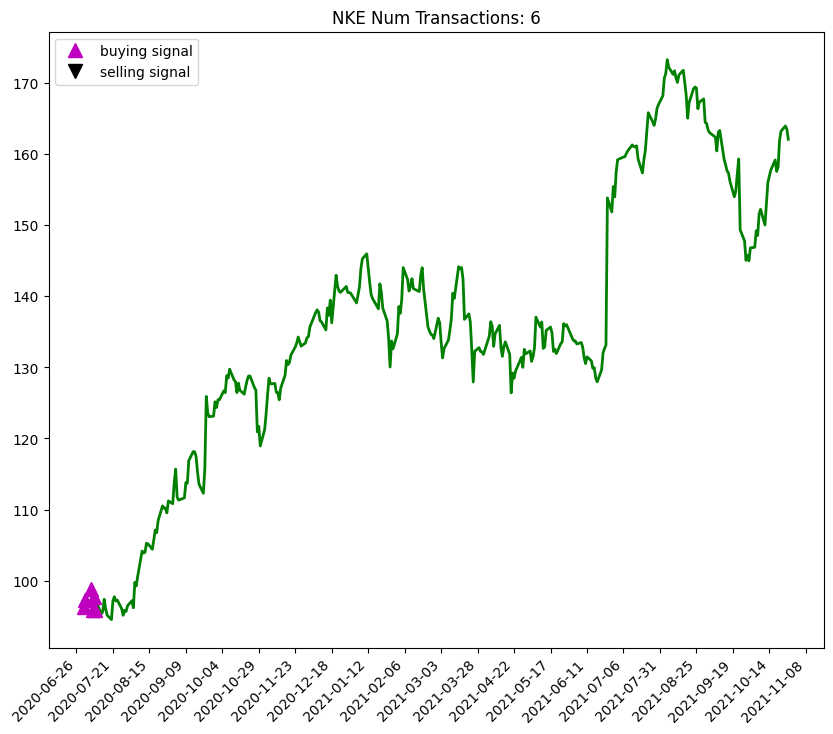

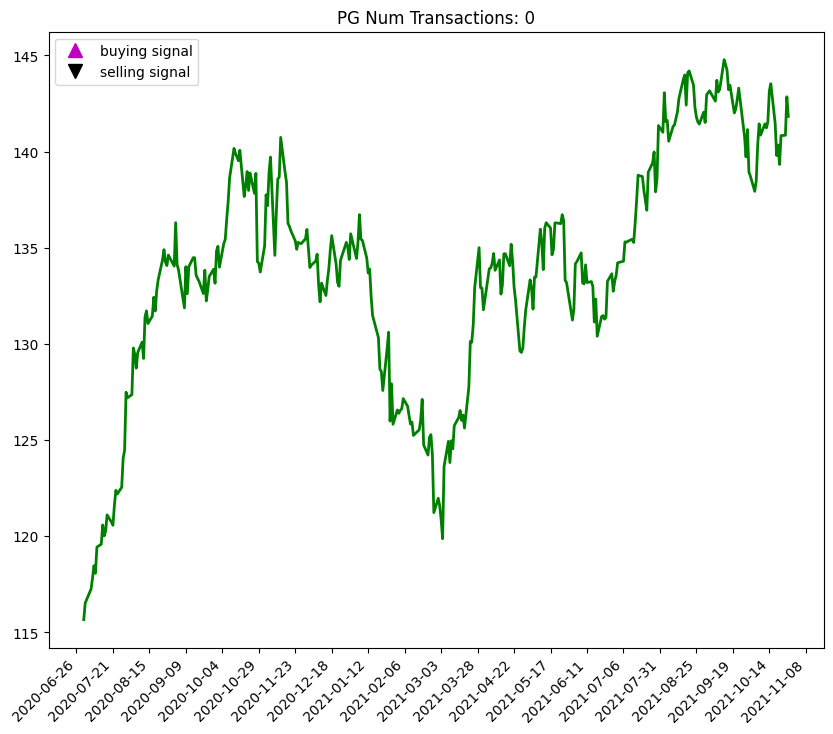

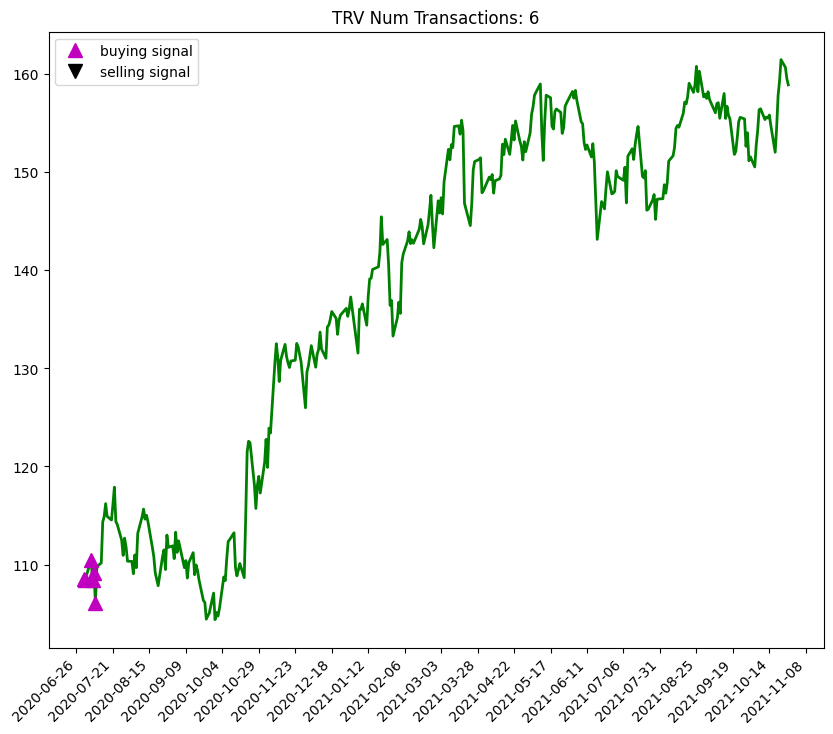

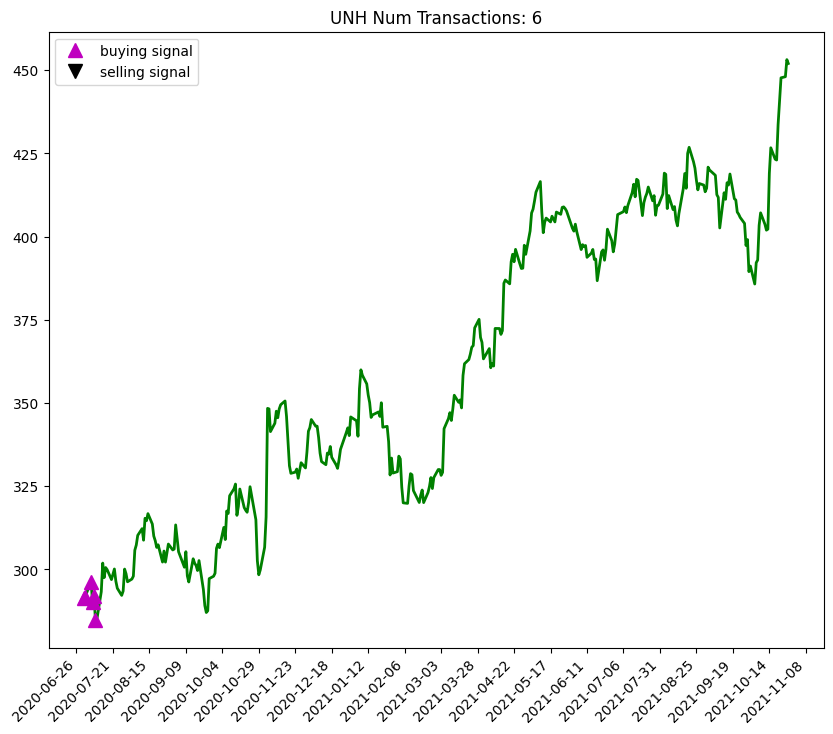

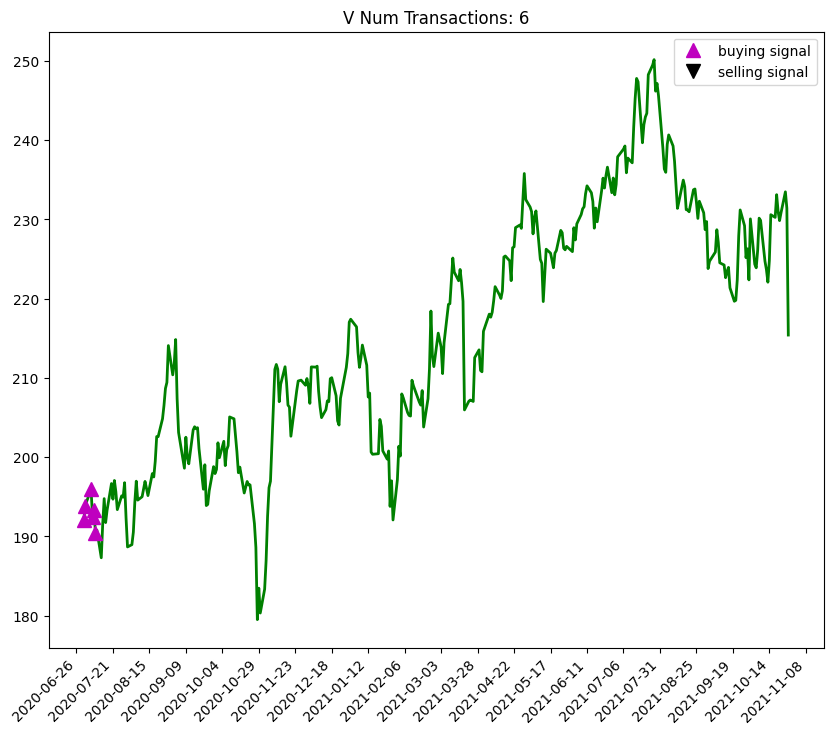

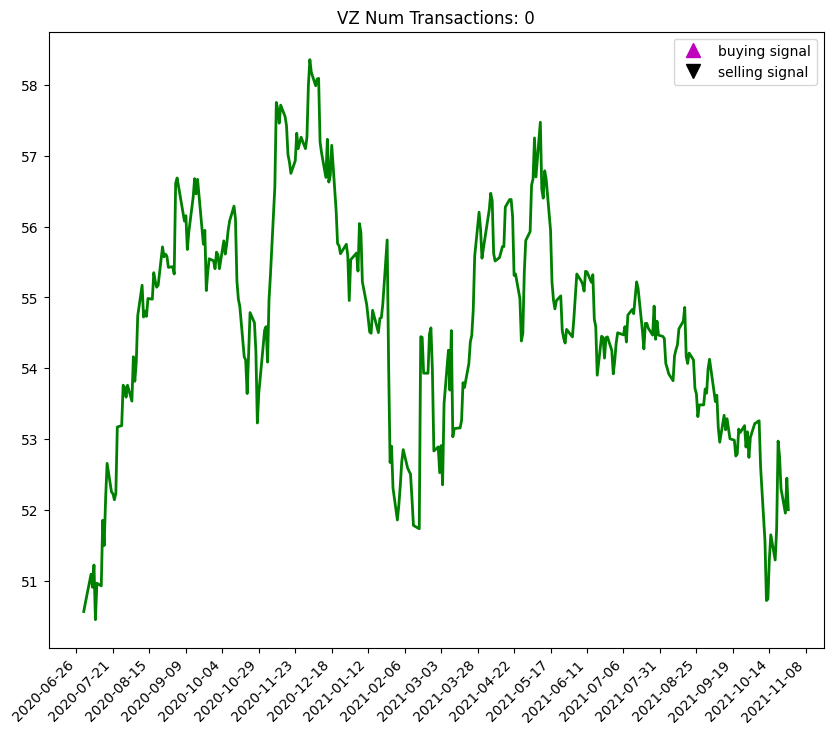

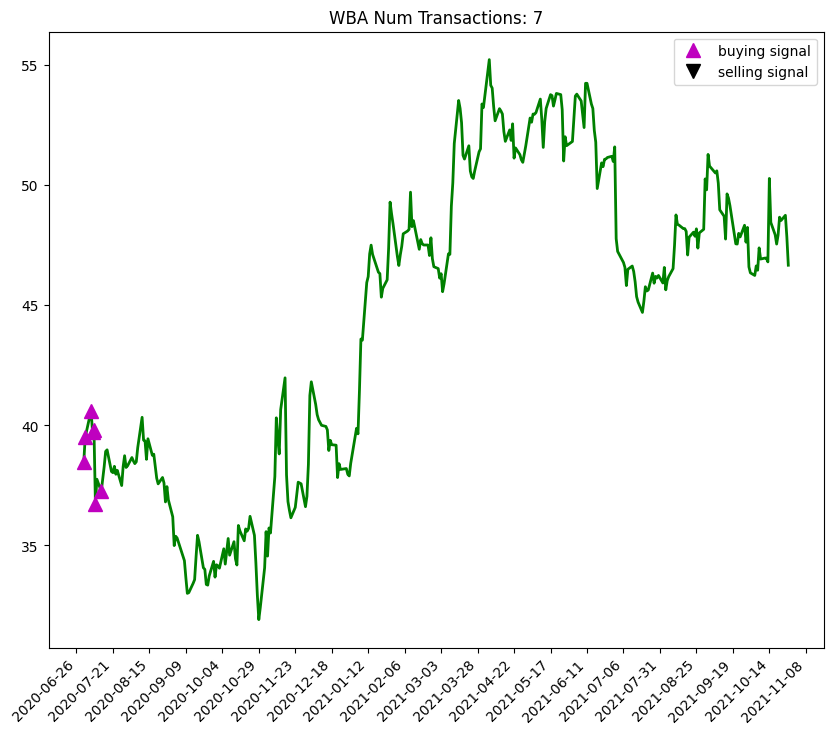

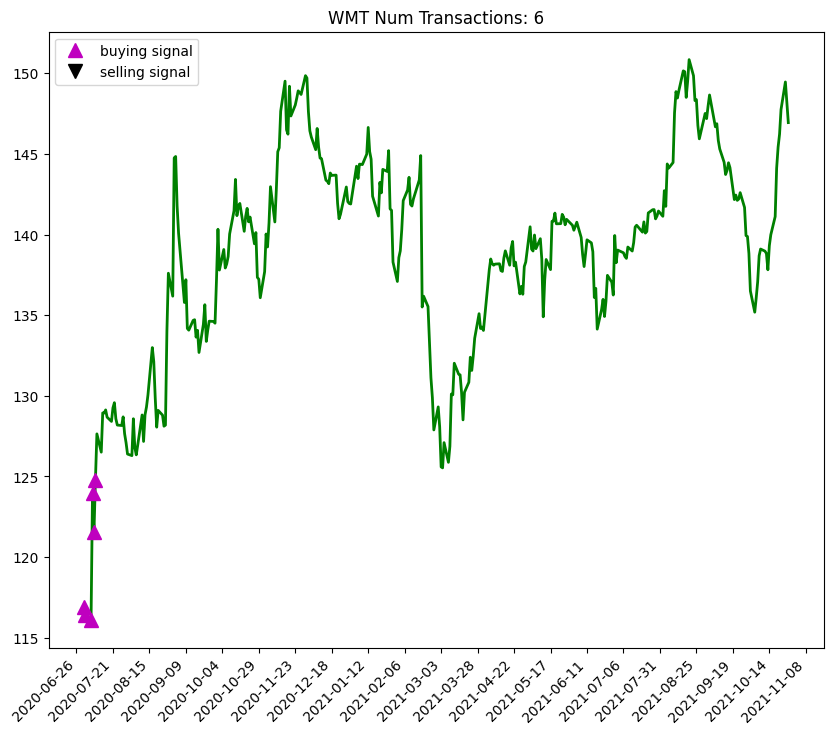

In [ ]:
def trx_plot(df_trade, df_actions, tics=None):
    """Plot transactions."""
    import matplotlib.dates as mdates

    df_trx = df_actions

    if tics is None:
        tics = list(df_trx)

    for tic in tics:
        df_trx_temp = df_trx[tic]
        df_trx_temp_sign = np.sign(df_trx_temp)
        buying_signal = df_trx_temp_sign.apply(lambda x: True if x > 0 else False)
        selling_signal = df_trx_temp_sign.apply(lambda x: True if x < 0 else False)

        tic_plot = df_trade[
            (df_trade["tic"] == df_trx_temp.name)
            & (df_trade["date"].isin(df_trx.index))
        ]["close"]
        tic_plot.index = df_trx_temp.index

        plt.figure(figsize=(10, 8))
        plt.plot(tic_plot, color="g", lw=2.0)
        plt.plot(
            tic_plot,
            "^",
            markersize=10,
            color="m",
            label="buying signal",
            markevery=buying_signal,
        )
        plt.plot(
            tic_plot,
            "v",
            markersize=10,
            color="k",
            label="selling signal",
            markevery=selling_signal,
        )
        plt.title(
            f"{df_trx_temp.name} Num Transactions: {len(buying_signal[buying_signal==True]) + len(selling_signal[selling_signal==True])}"
        )
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=25))
        plt.xticks(rotation=45, ha="right")
        plt.show()

trx_plot(trade, df_actions)